In [1]:
import re
import os
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
import seaborn as sns
import numpy as np
from IPython.display import HTML

In the first pass, we do a rough tokenization of the authentication log. We don't actually know how many different 'auth_source' types to expect, so we need to do some analysis to understand this better.

# Read the logs and do first coarse parsing

In [2]:
auth_parse = '^([A-Z][a-z]{2} [0-9\ ]\d \d{2}:\d{2}:\d{2}) ([a-z0-9A-Z][a-zA-Z0-9-]{0,62}) ([^:]+): (.*)$'
auth = []
with open("./all_auth_logs.txt") as f:
  lines = f.readlines()
  for line in lines:
    m = re.findall(auth_parse, line)
    auth_d = {
      'timestamp': dt.datetime.strptime(m[0][0], '%b %d %H:%M:%S').replace(year=2020),
      'hostname': m[0][1],
      'auth_source': m[0][2],
      'message': m[0][3]
    }
    auth.append(auth_d)

In [3]:
df = pd.DataFrame(auth)
df['auth_type'] = ''
df['auth_pid'] = -1

# Parse out the different auth sources

In [4]:
ssh_idx = df['auth_source'].str.startswith('sshd')
df.loc[ssh_idx, 'auth_type'] = 'ssh'
df.loc[ssh_idx, 'auth_pid'] = df.loc[ssh_idx, 'auth_source'].apply(lambda x: re.findall('sshd\[(\d+)\]',x)[0])

cron_idx = df['auth_source'].str.startswith('CRON')
df.loc[cron_idx, 'auth_type'] = 'cron'
df.loc[cron_idx, 'auth_pid'] = df.loc[cron_idx, 'auth_source'].apply(lambda x: re.findall('CRON\[\d+\]', x)[0])

login_idx = df['auth_source'].str.startswith('systemd-logind')
df.loc[login_idx, 'auth_type'] = 'physical_login'
df.loc[login_idx, 'auth_pid'] = df.loc[login_idx, 'auth_source'].apply(lambda x: re.findall('systemd-logind\[(\d+)\]', x)[0])

gnome_keyring = df['auth_source'].str.startswith('gnome-keyring-daemon')
df.loc[gnome_keyring, 'auth_type'] = 'gnome_keyring'
df.loc[gnome_keyring, 'auth_pid'] = df.loc[gnome_keyring, 'auth_source'].apply(lambda x: re.findall('gnome-keyring-daemon\[(\d+)\]', x)[0])

pkexec = df['auth_source'].str.startswith('pkexec')
df.loc[pkexec, 'auth_type'] = 'pkexec'

systemd = df['auth_source'].str.startswith('systemd')
df.loc[systemd, 'auth_type'] = 'physical_login'

polkitid = df['auth_source'].str.startswith('polk')
df.loc[polkitid, 'auth_type'] = 'polk'

gdm_password = df['auth_source'].str.startswith('gdm-password')
df.loc[gdm_password, 'auth_type'] = 'gdm_pass'

sudo = df['auth_source'].str.startswith('sudo')
df.loc[sudo, 'auth_type'] = 'sudo'

sudo = df['auth_source'].str.startswith('dbus')
df.loc[sudo, 'auth_type'] = 'dbus'

gdm = df['auth_source'].str.startswith('gdm-launch-env')
df.loc[gdm, 'auth_type'] = 'gdm-launch'

su = df['auth_source'].str.startswith('su[')
df.loc[su, 'auth_type'] = 'switch_user'

df.loc[df['auth_type'] == '', 'auth_type'] = 'other'

In [5]:
df

,timestamp,hostname,auth_source,message,auth_type,auth_pid
0,2020-11-08 00:09:54,computer,sshd[1492],Failed password for root from 81.68.100.138 po...,ssh,1492
1,2020-11-08 00:09:54,computer,sshd[1492],Received disconnect from 81.68.100.138 port 43...,ssh,1492
2,2020-11-08 00:09:54,computer,sshd[1492],Disconnected from authenticating user root 81....,ssh,1492
3,2020-11-08 00:09:55,computer,sshd[1494],Failed password for root from 51.254.120.159 p...,ssh,1494
4,2020-11-08 00:09:55,computer,sshd[1494],Received disconnect from 51.254.120.159 port 4...,ssh,1494
...,...,...,...,...,...,...
264814,2020-10-17 23:33:46,computer,sshd[2971],pam_unix(sshd:auth): authentication failure; l...,ssh,2971
264815,2020-10-17 23:33:47,computer,sshd[2970],Failed password for root from 85.209.0.253 por...,ssh,2970
264816,2020-10-17 23:33:48,computer,sshd[2971],Failed password for root from 85.209.0.253 por...,ssh,2971
264817,2020-10-17 23:33:48,computer,sshd[2970],Connection closed by authenticating user root ...,ssh,2970


# Parse the interesting stuff - ssh

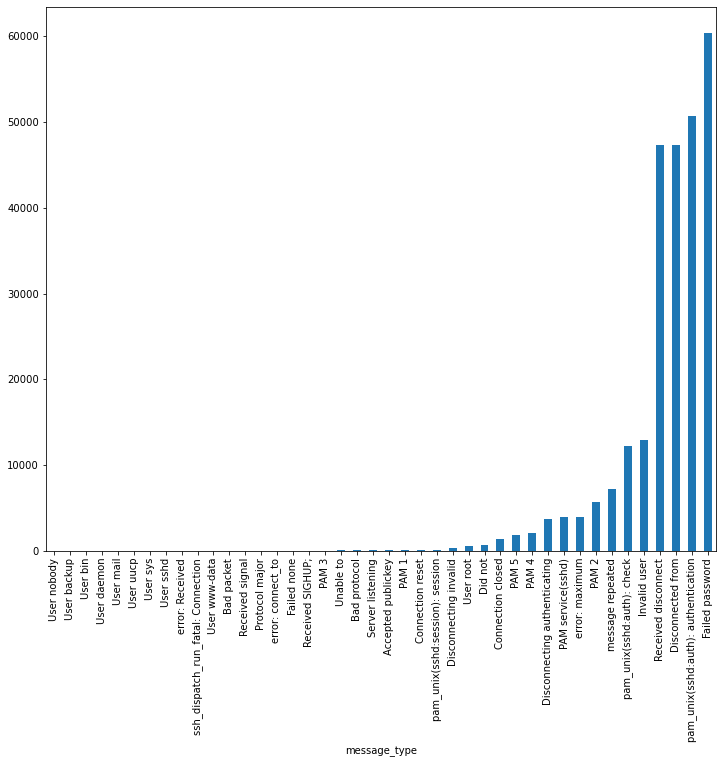

In [6]:
# Get a sense for the message types:
ssh_df = df[df['auth_type'] == 'ssh'].copy(deep=True)
ssh_df['message_type'] = ssh_df['message'].apply(lambda x: ' '.join(x.split(' ')[0:2]))
fig, ax = plt.subplots(figsize=(12, 10))
ssh_df.groupby('message_type').count()['hostname'].sort_values().plot.bar(ax=ax)

In [7]:
ssh_df['message_type'].value_counts() / ssh_df['message_type'].value_counts().sum()

Failed password                        0.229759
pam_unix(sshd:auth): authentication    0.193083
Disconnected from                      0.179887
Received disconnect                    0.179879
Invalid user                           0.049149
pam_unix(sshd:auth): check             0.046618
message repeated                       0.027438
PAM 2                                  0.021608
error: maximum                         0.014984
PAM service(sshd)                      0.014817
Disconnecting authenticating           0.014280
PAM 4                                  0.007823
PAM 5                                  0.006898
Connection closed                      0.005148
Did not                                0.002633
User root                              0.002150
Disconnecting invalid                  0.001309
pam_unix(sshd:session): session        0.000495
Connection reset                       0.000422
PAM 1                                  0.000350
Accepted publickey                     0

In [8]:
set(ssh_df[ssh_df['message'].str.startswith('Accepted')]['message'].apply(lambda x: x.split()[5]))

{'12.37.122.194', '192.168.86.1'}

In [9]:
for message in ssh_df[ssh_df['message'].str.startswith('pam_unix(sshd:auth)')]['message'][0:20]:
  print(message)

pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=139.199.14.128  user=root
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=198.199.68.76  user=root
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=213.39.55.13  user=root
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=175.24.49.95  user=root
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=218.92.0.185  user=root
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=189.178.10.88  user=root
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=152.136.237.47  user=root
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=218.92.0.185  user=root
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=150.158.15

It seems like the vast majority of the logs we're getting from auth is coming from failed SSH attempts. Lets look at some of them.

In [10]:
for message in ssh_df[ssh_df['message'].str.startswith('Failed')]['message'][0:20]:
  print(message)

Failed password for root from 81.68.100.138 port 43486 ssh2
Failed password for root from 51.254.120.159 port 49816 ssh2
Failed password for root from 139.199.14.128 port 33088 ssh2
Failed password for root from 198.199.68.76 port 43916 ssh2
Failed password for root from 213.39.55.13 port 55644 ssh2
Failed password for root from 175.24.49.95 port 36512 ssh2
Failed password for root from 218.92.0.185 port 22855 ssh2
Failed password for root from 218.92.0.185 port 22855 ssh2
Failed password for root from 189.178.10.88 port 60064 ssh2
Failed password for root from 152.136.237.47 port 56382 ssh2
Failed password for root from 218.92.0.185 port 22855 ssh2
Failed password for root from 218.92.0.185 port 51623 ssh2
Failed password for root from 218.92.0.185 port 51623 ssh2
Failed password for root from 150.158.152.244 port 43246 ssh2
Failed password for root from 218.92.0.185 port 21589 ssh2
Failed password for root from 198.199.68.76 port 55958 ssh2
Failed password for root from 119.29.138.19

In [11]:
parse_invalid = r'^Failed password for invalid user (\S+) from (\S+) port (\S+) ssh2$'
parse_valid   = r'^Failed password for (\S+) from (\S+) port (\S+) ssh2$'

In [12]:
for message in ssh_df[ssh_df['message'].str.startswith('Failed')]['message'][0:20]:
  print(re.findall(parse_invalid, message))

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [13]:
for message in ssh_df[ssh_df['message'].str.startswith('Failed')]['message'][0:20]:
  print(re.findall(parse_valid, message))

[('root', '81.68.100.138', '43486')]
[('root', '51.254.120.159', '49816')]
[('root', '139.199.14.128', '33088')]
[('root', '198.199.68.76', '43916')]
[('root', '213.39.55.13', '55644')]
[('root', '175.24.49.95', '36512')]
[('root', '218.92.0.185', '22855')]
[('root', '218.92.0.185', '22855')]
[('root', '189.178.10.88', '60064')]
[('root', '152.136.237.47', '56382')]
[('root', '218.92.0.185', '22855')]
[('root', '218.92.0.185', '51623')]
[('root', '218.92.0.185', '51623')]
[('root', '150.158.152.244', '43246')]
[('root', '218.92.0.185', '21589')]
[('root', '198.199.68.76', '55958')]
[('root', '119.29.138.191', '59000')]
[('root', '81.68.100.138', '51810')]
[('root', '51.254.120.159', '49593')]
[('root', '106.12.26.131', '49808')]


Looks like its working - lets pull out all failed login attempts and understand what's going on here.

In [14]:
fail_df = ssh_df[ssh_df['message'].str.startswith('Failed')].copy(deep=True)

In [15]:
def parse_message(message):
  message = message['message']
  
  parse_invalid = r'^Failed password for invalid user (\S+) from (\S+) port (\S+) ssh2$'
  parse_valid   = r'^Failed password for (\S+) from (\S+) port (\S+) ssh2$'
  parse_none    = r'^Failed none for invalid user (\S+) from (\S+) port (\S+) ssh2$'
  parse_blank_1 = r'^Failed none for invalid user  from (\S+) port (\S+) ssh2$'
  parse_blank_2 = r'^Failed password for invalid user  from (\S+) port (\S+) ssh2$'
  
  m1 = re.findall(parse_invalid, message)
  m2 = re.findall(parse_valid, message)
  m3 = re.findall(parse_none, message)
  m4 = re.findall(parse_blank_1, message)
  m5 = re.findall(parse_blank_2, message)
  
  user = ''
  source_ip = ''
  port = ''
  
  try:
    user = m1[0][0]
    source_ip = m1[0][1]
    port = m1[0][2]
  except IndexError:
    try:
      user = m2[0][0]
      source_ip = m2[0][1]
      port = m2[0][2]
    except IndexError:
      try:
        user = m3[0][0]
        source_ip = m3[0][1]
        port = m3[0][2]
      except:
        try:
          user = 'none'
          source_ip = m4[0][0]
          port = m4[0][1]
        except:
          try:
            user = 'none'
            source_ip = m5[0][0]
            port = m5[0][1]
          except:
            pass
  
  return user, source_ip, port

message = fail_df.apply(func=parse_message, axis=1, result_type='expand').rename(columns={0:'user', 1:'source_ip', 2:'port'})

In [16]:
df = pd.concat([fail_df, message], axis=1) 

In [17]:
df['unixtime'] = df['timestamp'].apply(lambda x: time.mktime(x.timetuple()))

In [18]:
df['user'].value_counts()[df['user'].value_counts() > 6]

root      48040
admin       749
test        359
ubuntu      303
user        297
          ...  
cron          7
liy           7
jeremy        7
ana           7
xu            7
Name: user, Length: 321, dtype: int64

In [19]:
# Pagate and view
rollover = 30

logins = (df['user'].value_counts()
  .sort_index()
  .reset_index()
  .rename(columns={'index':'login', 'user':'number'})
)

start_idx = 0
end_idx = rollover

pagated = []

while start_idx < len(logins):
  pagated.append(logins[start_idx:end_idx].reset_index().loc[:,['login', 'number']])
  start_idx += rollover
  end_idx += rollover
  
HTML(pd.concat(pagated, axis=1).to_html())

,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number,login,number
0,!!Aa1123!,1,1234,15,1q@W3e$R,2,Admin.12*,1,P@@Ssw0rd1,1,QWEcloud,1,Welcome@888!,1,abcd,5,administrat0r1,1,alfredo,2,andrea,5,apc,6,as,3,baptiste,2,bitch,2,bwadmin,2,celia,2,claudia,4,confluence,3,cubrid,1,database,2,demo2,1,dl,6,eclipse,4,enc,1,facturacion,1,fmaster,2,ftptest,37,github,1,haldaemon,2,huawei,45,intranet,2,janice,1,jk,1,julius,3,kiosk,4,lee,4,liuhao,4,luke,1,marc,2,matlab,1,micha,3,mongodb,1,nagesh,3,nikita,5,odoo11,1,operador,2,packer,4,pawel,1,pmi,1,programacion,4,qwe123!@#,1,ram,5,reza,2,root123467,1,sagar,2,scanner,5,sga,4,sk,5,spring,1,student4,1,sysman,8,tech,3,testadmin,3,timemachine,2,travel,3,umcapasocanoas,1,user5,2,vikas,3,vss,2,werkstatt,2,wwadmin,6,yan,4,znc-admin,2.0
1,!!Aa123456,2,12341234,2,1qasdrtyujkl,1,Admin.123.,1,P@ri$_75!,1,QWErtyUIOp[],1,WinDdos*,3,abcde123456,1,administrator,42,alfresco,1,andreas,1,api,1,asd,1,barry,2,bitnami,4,c,2,cent,6,claudio,4,connect,5,culture,2,datacenterhetzner,1,demon,2,dm,1,ecs-user,1,engin,3,family,3,foo,4,ftpu,1,gitlab,3,hamza,4,hub,1,invitado,4,jared,3,jm,2,junior,3,kiran,6,leon,8,live,5,luo,4,marcel,2,matrix,1,michael,14,monica,5,nagios,28,nisec,5,odroid,5,operator,10,paco,2,pc,3,pmiadmin,1,proxy,6,qwe123QWE!@,1,ramesh,1,rf,6,root2020,1,sahil,1,sce,2,sgeadmin,2,skaner,2,sqoop,3,student5,3,sysop,2,techuser,5,testbed,1,ting,3,travis,4,unity,6,user6,5,viktor,4,vtcbikes,4,wesley,3,www,51,yang,4,zookeeper,4.0
2,!@#!@#,1,12345,2,1qawsedrftg,1,Admin.999,1,P@ss1,1,Qaz!@#123654,1,Youda17*,1,abcs,4,administratoridc123456,1,ali,9,andrei,5,app,29,asd2020,1,bart,2,bitrix,4,ca,1,center,1,clement,2,console,3,cumulus,1,david,5,demouser,1,dmdba,4,ecs-user1,1,engineer,1,farhan,1,formation,4,ftpuser,203,gitlab-runner,1,haoyu,2,hue,3,invite,4,jason,6,jo,2,jupyter,5,kk,3,leonard,1,liwei,4,lw,4,marcela,5,matt,1,michal,3,monitor,9,nancy,2,nitin,1,ofbiz,2,ops,6,pacs,1,pcguest,3,polaris,2,prueba,45,qwe@asd123,1,ramon,1,rg,2,root2233445566,1,sai,6,school,5,sgp,5,sklep,2,squid,2,student6,2,system,22,tecnici,3,testdev,3,tiptop,5,trinity,8,uno50,3,user7,8,vinay,10,vyatta,10,wetserver,1,www-data,19,yhlee,2,zope,2.0
3,!@#$1234qwer,1,123456,7,1qaz!@#$%^,1,Admin2019!,1,P@ss@word!@#,1,Qaz123~,1,ZAQ!@WSXCDE#g,1,abdul,1,admintmbc2020,1,alias,1,andres,2,appadmin,1,asdf,2,base,3,bkp,3,cacti,3,centos,39,client,5,consul,5,cups,2,davide,2,dennis,5,dmitry,2,ed,2,eoffice,1,farmacia,4,fourjs,5,ftpuser1,8,gituser,25,haproxy,12,humberto,5,invoices,1,java,2,joan,2,justin,8,km,3,leonardo,5,liy,7,lx,6,marcelo,4,mattermost,7,michel,3,monitoring,6,nano,1,nmrsu,1,office,7,ops_tool,1,pan,4,pcl,2,poliana,4,prueba1,6,qweewqqwe,1,rancher,2,rh,1,root4321,1,salman,3,scott,1,shadow,4,sky,2,ss,3,student7,1,system!@#123,1,tecnico,1,teste,31,titan,1,trung,4,uno8,4,user8,5,vince,2,vyos,5,wh,7,wwwadmin,1,yolanda,1,zs,1.0
4,!@AS12as,1,1234561,1,1qaz2WSX!,1,Admin@4321,2,P@ssWord*.,1,Qw147,2,ZAQWSXCDE,1,abel,10,adminuser,13,alice,6,andrew,10,apparent,1,asdf!@#,1,basesystem,1,blog,1,cactiuser,7,centosuser1,2,client1,4,conta,3,customer,10,dayz,7,deploy,59,dms,2,edgar,5,epg,1,fastu

In [20]:
df_summary = pd.concat(
  [
    df[['source_ip', 'port']].groupby('source_ip').agg(lambda x: len(set(x))).rename(columns={'port':'num_ports_scanned'}),
    df[['source_ip', 'timestamp']].groupby('source_ip').max().rename(columns={'timestamp':'max_timestamp'}),
    df[['source_ip', 'timestamp']].groupby('source_ip').min().rename(columns={'timestamp':'min_timestamp'}),
    df[['source_ip', 'timestamp']].groupby('source_ip').count().rename(columns={'timestamp':'number_of_attempts'}),
    df[['source_ip', 'user']].groupby('source_ip').agg(lambda x: len(set(x))).rename(columns={'user':'uname_count'}),
    df[['source_ip', 'timestamp']].groupby('source_ip').agg(lambda x: list(x)).rename(columns={'timestamp':'timeseries'}),
    df[['source_ip', 'unixtime']].groupby('source_ip').min().rename(columns={'unixtime':'min_unixtime'}),
    df[['source_ip', 'unixtime']].groupby('source_ip').max().rename(columns={'unixtime':'max_unixtime'}),
    df[['source_ip', 'unixtime']].groupby('source_ip').agg(lambda x: list(x)).rename(columns={'unixtime':'unixtime_timeseries'})
  ],
  axis=1
)
df_summary['ats'] = df_summary['number_of_attempts'] / (df_summary['max_unixtime'] - df_summary['min_unixtime'])
df_summary.sort_values(by='number_of_attempts', ascending=False).head(10)

,num_ports_scanned,max_timestamp,min_timestamp,number_of_attempts,uname_count,timeseries,min_unixtime,max_unixtime,unixtime_timeseries,ats
source_ip,,,,,,,,,,
218.92.0.205,2682,2020-10-23 16:25:12,2020-10-19 08:23:24,3422,1,"[2020-10-19 08:23:24, 2020-10-19 08:28:02, 202...",1.603096e+09,1.603470e+09,"[1603095804.0, 1603096082.0, 1603096154.0, 160...",0.009137
49.88.112.77,1247,2020-11-10 10:18:35,2020-11-08 08:15:35,2584,1,"[2020-11-08 08:15:35, 2020-11-08 08:16:46, 202...",1.604823e+09,1.605004e+09,"[1604823335.0, 1604823406.0, 1604823408.0, 160...",0.014341
218.92.0.204,1232,2020-10-27 09:14:39,2020-10-18 09:03:44,1556,1,"[2020-10-27 09:13:43, 2020-10-27 09:14:39, 202...",1.603012e+09,1.603790e+09,"[1603790023.0, 1603790079.0, 1603011824.0, 160...",0.001999
218.92.0.206,664,2020-11-08 04:31:05,2020-10-29 08:57:18,1392,1,"[2020-11-08 00:16:08, 2020-11-08 00:17:24, 202...",1.603962e+09,1.604810e+09,"[1604794568.0, 1604794644.0, 1604794647.0, 160...",0.001641
122.194.229.122,177,2020-11-10 05:51:19,2020-10-18 22:37:17,381,1,"[2020-11-08 00:28:21, 2020-11-08 00:28:40, 202...",1.603061e+09,1.604987e+09,"[1604795301.0, 1604795320.0, 1604795341.0, 160...",0.000198
61.177.172.61,166,2020-11-10 09:24:56,2020-10-18 13:28:25,356,1,"[2020-11-08 02:51:35, 2020-11-08 02:51:38, 202...",1.603028e+09,1.605000e+09,"[1604803895.0, 1604803898.0, 1604803914.0, 160...",0.000180
112.85.42.110,161,2020-11-10 02:25:46,2020-10-18 14:29:31,350,1,"[2020-11-08 02:00:51, 2020-11-08 02:00:54, 202...",1.603031e+09,1.604975e+09,"[1604800851.0, 1604800854.0, 1604800857.0, 160...",0.000180
112.85.42.196,177,2020-11-10 07:17:16,2020-10-19 06:19:11,348,1,"[2020-11-08 01:01:48, 2020-11-08 01:02:06, 202...",1.603088e+09,1.604993e+09,"[1604797308.0, 1604797326.0, 1604797348.0, 160...",0.000183
112.85.42.184,161,2020-11-10 10:07:55,2020-10-18 15:11:53,323,1,"[2020-11-08 06:04:04, 2020-11-08 06:04:23, 202...",1.603034e+09,1.605003e+09,"[1604815444.0, 1604815463.0, 1604815466.0, 160...",0.000164


In [21]:
!pip install ipwhois

In [22]:
from ipwhois import IPWhois
import os
import sys
import numpy as np
import time
import json

ip_country = {}

for ip in df_summary.index.unique():
  try:
    with open("ip_to_country_mapping.json", "r") as f:
      ip_country = json.load(f)
  except:
    pass
  if ip not in ip_country:
    print("processing", ip, "            ", end='\r')
    resp = IPWhois(ip)
    country = resp.lookup_whois()['asn_country_code']
    ip_country[ip] = country
    with open("ip_to_country_mapping.json", "w") as f:
      json.dump(ip_country, f)
    
print("Done")


Done


In [23]:
df_summary['country'] = pd.Series(ip_country)

Text(0.5, 1.0, 'Attacks by Country')

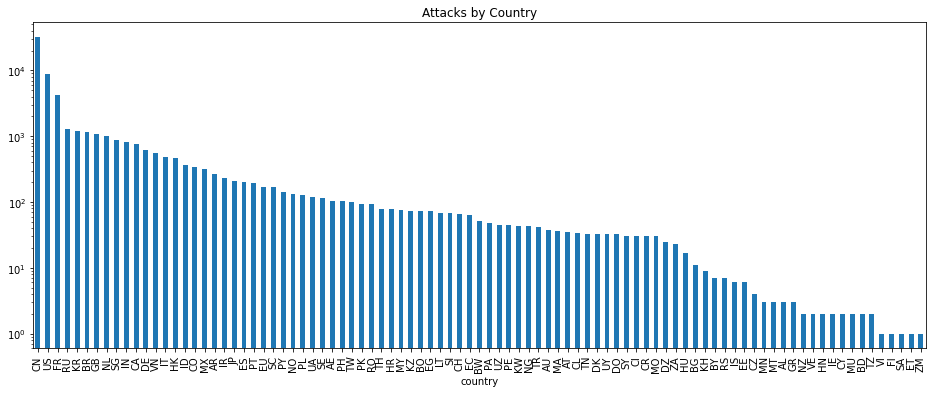

In [24]:
fig, ax = plt.subplots(figsize=(16,6))
df_summary.groupby('country').sum()['number_of_attempts'].sort_values(ascending=False).plot.bar(ax=ax, logy=True)
ax.set_title("Attacks by Country")

In [25]:
top_9 = df_summary.groupby('country').sum()['number_of_attempts'].sort_values(ascending=False)
top_9 = top_9[:9]

In [26]:
# plt_df = df_summary.loc[df_summary.index == '218.92.0.205']
countries = list(top_9.index)

In [27]:
print(countries, len(countries))

@mpl.ticker.FuncFormatter
def major_formatter(x, pos):
  return dt.datetime.utcfromtimestamp(x).strftime('%Y-%b-%d')


['CN', 'US', 'FR', 'RU', 'KR', 'BR', 'GB', 'NL', 'SG'] 9


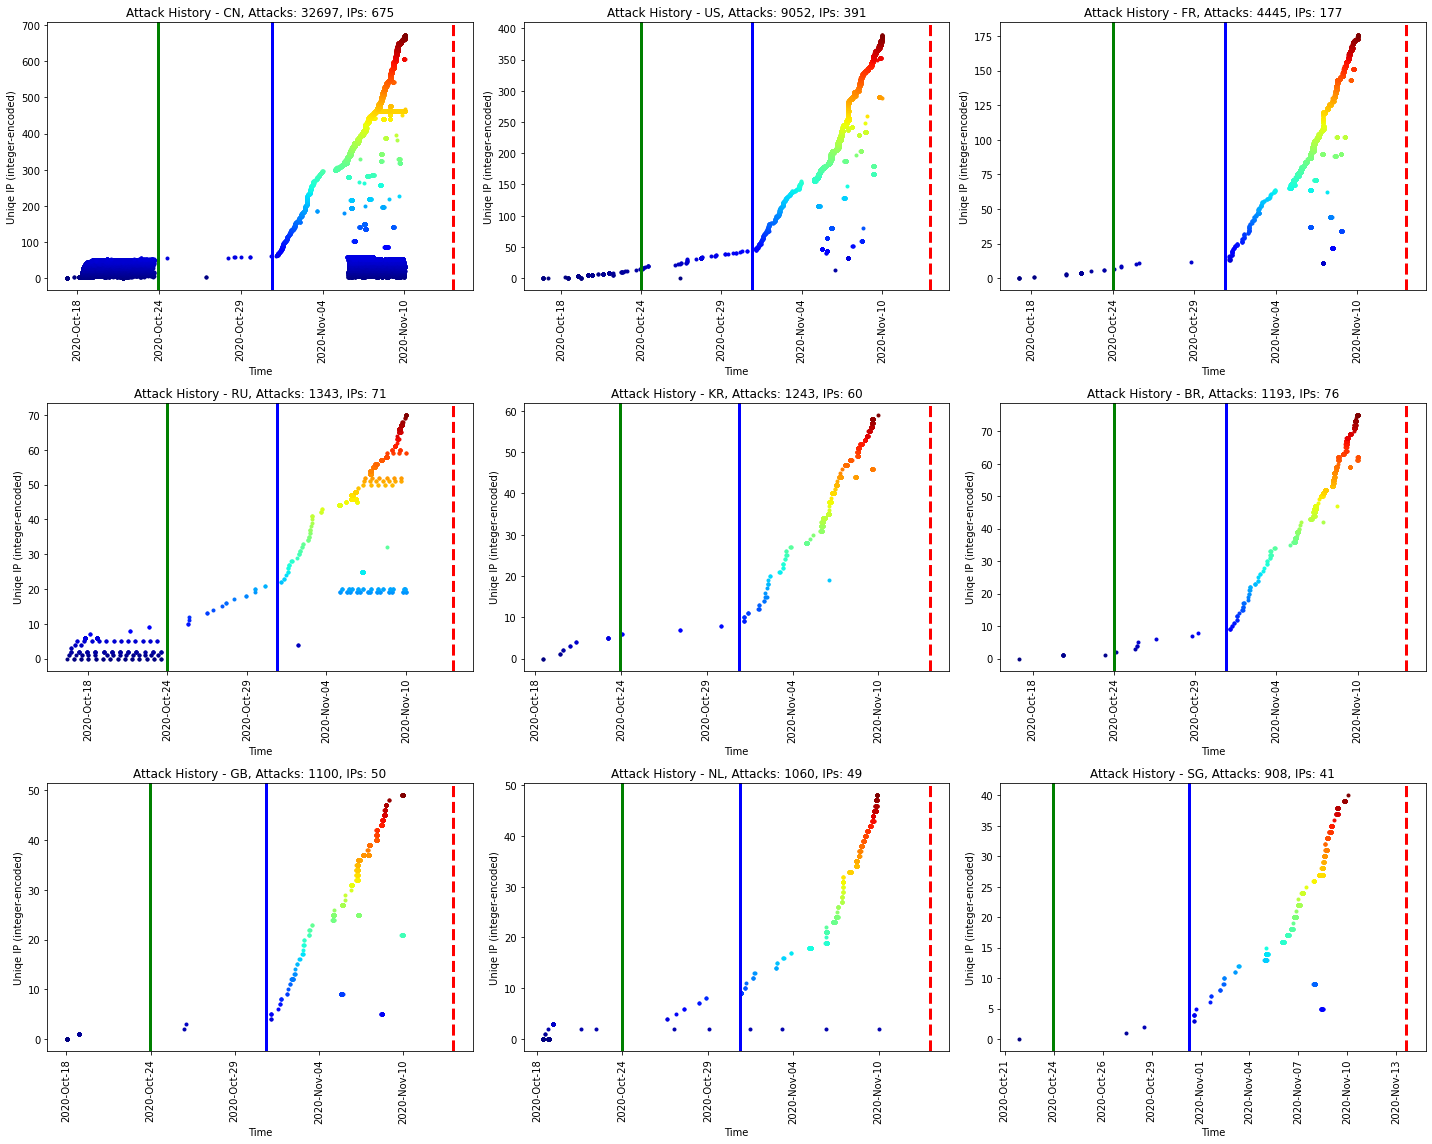

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,16))

for c_i, ax in enumerate(axes.reshape(-1)):
  plt.sca(ax)
  plt_df = df_summary.loc[df_summary['country'] == countries[c_i]]
  num_ips = len(plt_df.index)
  color = mpl.cm.jet(np.linspace(0, 1, len(plt_df)))
  attacks = 0
  for i, row in enumerate(plt_df.sort_values(by='min_unixtime').iterrows()):
    attacks += len(plt_df['unixtime_timeseries'])
    ip_address = row[0]
    plt_df = row[1]
    timeseries = plt_df['unixtime_timeseries']

    plt.scatter(
      timeseries,
      np.full(shape=(len(timeseries),), fill_value=i),
      label=ip_address,
      marker='.',
      color=color[i],
    )
    plt.xticks(rotation='90')
  
  ax.xaxis.set_major_formatter(major_formatter)
  ax.axvline(x=time.mktime(dt.datetime.now().timetuple()), ymin=0, ymax=i, color='r', linestyle='--', linewidth=3)
  ax.axvline(x=time.mktime(dt.datetime(2020,10,24).timetuple()), ymin=0, ymax=i, color='g', linestyle='-', linewidth=3)
  ax.axvline(x=time.mktime(dt.datetime(2020,11,1).timetuple()), ymin=0, ymax=i, color='b', linestyle='-', linewidth=3)
  ax.set_ylabel("Uniqe IP (integer-encoded)")
  ax.set_xlabel("Time")
  plt.title("Attack History - {}, Attacks: {}, IPs: {}".format(countries[c_i], attacks, num_ips))
plt.tight_layout()
plt.savefig("attacks.png")

The hard stop near October 25 was when fail2ban was installed on the server, with permanent bans implemented after three failed logins. Note that we saw one attack near the 29th where many new IP addresses started incoming. 

Large gaps in traffic correspond to the computer just being off.

In [29]:
df_summary.sort_values(by='number_of_attempts', ascending=False)

,num_ports_scanned,max_timestamp,min_timestamp,number_of_attempts,uname_count,timeseries,min_unixtime,max_unixtime,unixtime_timeseries,ats,country
source_ip,,,,,,,,,,,
218.92.0.205,2682,2020-10-23 16:25:12,2020-10-19 08:23:24,3422,1,"[2020-10-19 08:23:24, 2020-10-19 08:28:02, 202...",1.603096e+09,1.603470e+09,"[1603095804.0, 1603096082.0, 1603096154.0, 160...",0.009137,CN
49.88.112.77,1247,2020-11-10 10:18:35,2020-11-08 08:15:35,2584,1,"[2020-11-08 08:15:35, 2020-11-08 08:16:46, 202...",1.604823e+09,1.605004e+09,"[1604823335.0, 1604823406.0, 1604823408.0, 160...",0.014341,CN
218.92.0.204,1232,2020-10-27 09:14:39,2020-10-18 09:03:44,1556,1,"[2020-10-27 09:13:43, 2020-10-27 09:14:39, 202...",1.603012e+09,1.603790e+09,"[1603790023.0, 1603790079.0, 1603011824.0, 160...",0.001999,CN
218.92.0.206,664,2020-11-08 04:31:05,2020-10-29 08:57:18,1392,1,"[2020-11-08 00:16:08, 2020-11-08 00:17:24, 202...",1.603962e+09,1.604810e+09,"[1604794568.0, 1604794644.0, 1604794647.0, 160...",0.001641,CN
122.194.229.122,177,2020-11-10 05:51:19,2020-10-18 22:37:17,381,1,"[2020-11-08 00:28:21, 2020-11-08 00:28:40, 202...",1.603061e+09,1.604987e+09,"[1604795301.0, 1604795320.0, 1604795341.0, 160...",0.000198,CN
...,...,...,...,...,...,...,...,...,...,...,...
182.61.53.245,1,2020-11-03 12:24:51,2020-11-03 12:24:51,1,1,[2020-11-03 12:24:51],1.604406e+09,1.604406e+09,[1604406291.0],inf,CN
182.61.54.45,1,2020-11-02 22:21:03,2020-11-02 22:21:03,1,1,[2020-11-02 22:21:03],1.604356e+09,1.604356e+09,[1604355663.0],inf,CN
183.220.1.161,1,2020-11-03 17:17:06,2020-11-03 17:17:06,1,1,[2020-11-03 17:17:06],1.604424e+09,1.604424e+09,[1604423826.0],inf,CN


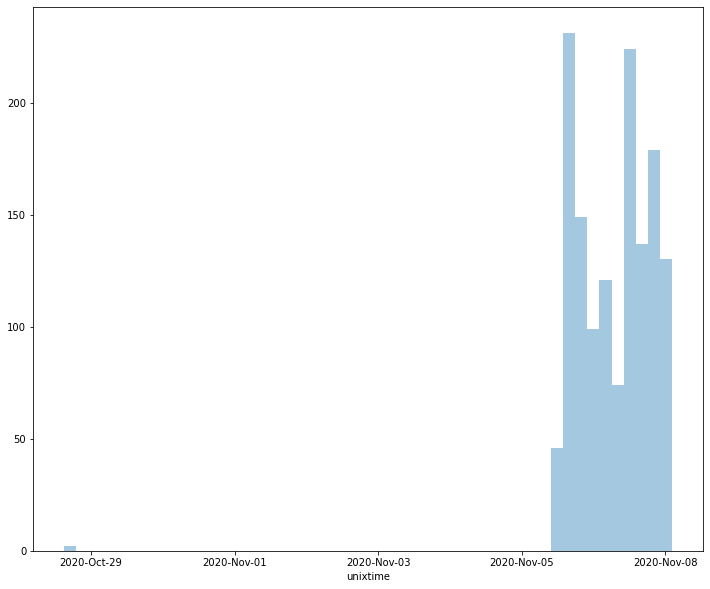

In [30]:
fig, ax = plt.subplots(figsize=(12,10))
sns.distplot(df[df['source_ip'] == '218.92.0.206'].sort_values(by='unixtime')['unixtime'], ax=ax, norm_hist=False, kde=False)
ax.xaxis.set_major_formatter(major_formatter)


In [31]:
df[(df['source_ip'] == '218.92.0.206') & (df['timestamp'] > "2020-11-06")]

,timestamp,hostname,auth_source,message,auth_type,auth_pid,message_type,user,source_ip,port,unixtime
92,2020-11-08 00:16:08,computer,sshd[2012],Failed password for root from 218.92.0.206 por...,ssh,2012,Failed password,root,218.92.0.206,12682,1.604795e+09
121,2020-11-08 00:17:24,computer,sshd[2029],Failed password for root from 218.92.0.206 por...,ssh,2029,Failed password,root,218.92.0.206,15168,1.604795e+09
125,2020-11-08 00:17:27,computer,sshd[2029],Failed password for root from 218.92.0.206 por...,ssh,2029,Failed password,root,218.92.0.206,15168,1.604795e+09
126,2020-11-08 00:17:29,computer,sshd[2029],Failed password for root from 218.92.0.206 por...,ssh,2029,Failed password,root,218.92.0.206,15168,1.604795e+09
180,2020-11-08 00:20:51,computer,sshd[2065],Failed password for root from 218.92.0.206 por...,ssh,2065,Failed password,root,218.92.0.206,32887,1.604795e+09
...,...,...,...,...,...,...,...,...,...,...,...
213306,2020-11-07 23:59:36,computer,sshd[1307],Failed password for root from 218.92.0.206 por...,ssh,1307,Failed password,root,218.92.0.206,29017,1.604794e+09
213524,2020-11-08 00:06:29,computer,sshd[1449],Failed password for root from 218.92.0.206 por...,ssh,1449,Failed password,root,218.92.0.206,14360,1.604794e+09
213560,2020-11-08 00:07:33,computer,sshd[1466],Failed password for root from 218.92.0.206 por...,ssh,1466,Failed password,root,218.92.0.206,28715,1.604794e+09
213562,2020-11-08 00:07:36,computer,sshd[1466],Failed password for root from 218.92.0.206 por...,ssh,1466,Failed password,root,218.92.0.206,28715,1.604794e+09


In [32]:
df_summary.shape

(2205, 11)